/tmp/ipykernel_9999/2091170579.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_9999/2091170579.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


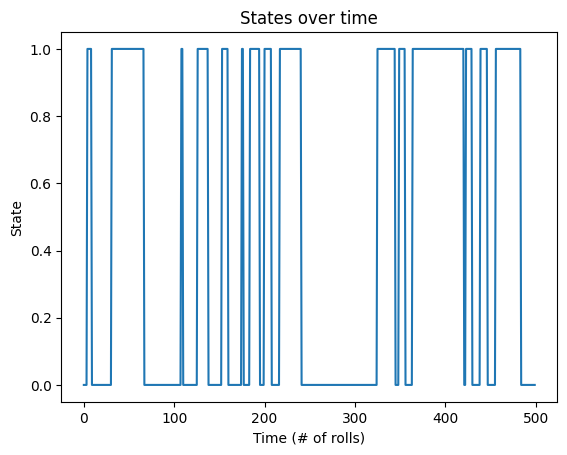

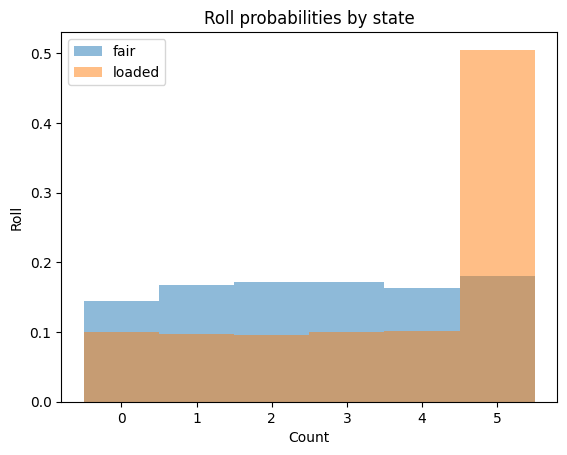

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm

# make our generative model with two components, a fair die and a
# loaded die
gen_model = hmm.CategoricalHMM(n_components=2, random_state=99)

# the first state is the fair die so let's start there so no one
# catches on right away
gen_model.startprob_ = np.array([1.0, 0.0])

# now let's say that we sneak the loaded die in:
# here, we have a 95% chance to continue using the fair die and a 5%
# chance to switch to the loaded die
# when we enter the loaded die state, we have a 90% chance of staying
# in that state and a 10% chance of leaving
gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])

# now let's set the emission means:
# the first state is a fair die with equal probabilities and the
# second is loaded by being biased toward rolling a six
gen_model.emissionprob_ = \
    np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],
              [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 2]])

# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(3000)

# plot states over time, let's just look at the first rolls for clarity
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
fig.show()

# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.set_title('Roll probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()
fig.show()


In [ ]:
++++++++++++

In [ ]:
# import pickle

# with open('/home/david/Documents/code/phd/test.pkl', 'wb') as file:
#                 pickle.dump(gen_model, file)

# with open('/home/david/Documents/code/phd/test.pkl', 'rb') as file:
#                 test_model = pickle.load(file)

In [ ]:
# test_model.transmat_

array([[0.95, 0.05],
       [0.1 , 0.9 ]])

Model #0	Score: -2629.2607443452025
Model #1	Score: -2629.6814168933056
Model #2	Score: -2641.421890412749
Model #3	Score: -2630.896193507156
Model #4	Score: -2629.6819076204056
Model #5	Score: -2627.0761052492585
Model #6	Score: -2631.0976858225285
Model #7	Score: -2617.16037789528
Model #8	Score: -2614.9351275746317
Model #9	Score: -2629.681398573409
Model #10	Score: -2629.6818860713543
Model #11	Score: -2639.6624150250923
Model #12	Score: -2615.300074070875
Model #13	Score: -2631.105931734744
Model #14	Score: -2617.508108722029
Model #15	Score: -2615.0416278489647
Model #16	Score: -2616.931394544873
Model #17	Score: -2630.8889095514974
Model #18	Score: -2622.6932112580785
Model #19	Score: -2640.2808953596077
Model #20	Score: -2628.575614570286
Model #21	Score: -2629.6834481206215
Model #22	Score: -2631.097522971609
Model #23	Score: -2629.681396840646
Model #24	Score: -2625.4775833550602
Model #25	Score: -2629.681398975583
Model #26	Score: -2624.2120593747013
Model #27	Score: -2630.7

/tmp/ipykernel_9999/2250954858.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


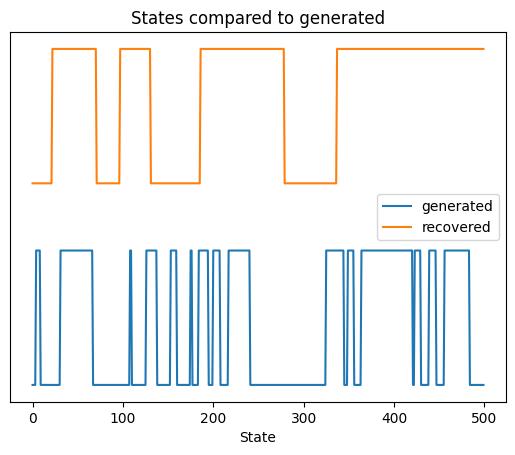

In [8]:
# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

# check optimal score
gen_score = gen_model.score(X_validate)

best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.CategoricalHMM(
        n_components=2, random_state=idx,
        init_params='se')  # don't init transition, set it below
    # we need to initialize with random transition matrix probabilities
    # because the default is an even likelihood transition
    # we know transitions are rare (otherwise the casino would get caught!)
    # so let's have an Dirichlet random prior with an alpha value of
    # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
    # of the time
    model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                                np.random.dirichlet([0.1, 0.9])])
    model.fit(X_train)
    score = model.score(X_validate)
    print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Generated score: {gen_score}\nBest score:      {best_score}')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(rolls)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(abs(states[:500]-1) + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()
fig.show()

In [9]:
X_train

array([[2],
       [0],
       [3],
       ...,
       [3],
       [5],
       [4]], shape=(1500, 1))

In [ ]:
print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n\n')

Transmission Matrix Generated:
[[0.95 0.05]
 [0.1  0.9 ]]

Transmission Matrix Recovered:
[[0.946 0.054]
 [0.055 0.945]]




In [ ]:
print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n\n')

Emission Matrix Generated:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.1   0.1   0.1   0.1   0.1   0.5  ]]

Emission Matrix Recovered:
[[0.076 0.115 0.137 0.11  0.118 0.443]
 [0.175 0.164 0.147 0.192 0.165 0.158]]




In [ ]:
np.array(['a','b'])

array(['a', 'b'], dtype='<U1')

In [ ]:
model.transmat_

array([[9.99998053e-01, 1.94688451e-06],
       [4.89591319e-02, 9.51040868e-01]])

In [ ]:
x = [1,2,3,4,5,6,7,8,9]

x[1,2,3]

TypeError: list indices must be integers or slices, not tuple